In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(42)

### Problem1

### a.

In [5]:
train = pd.read_csv('../HW3/hw3-data/ratings_train.csv', header=None)
train.columns = ['user_id', 'movie_id', 'rating']
test = pd.read_csv('../HW3/hw3-data/ratings_test.csv', header=None)
test.columns = ['user_id', 'movie_id', 'rating']
movie = pd.read_fwf('../HW3/hw3-data/movies.txt', header=None, sep='\n')
movie.columns = ['movie_name']
movie.head(10)
print(train.shape)
print(test.shape)
print(movie.shape)

(95000, 3)
(5000, 3)
(1682, 1)


In [6]:
SIGMA = 0.25
D = 10
LAMBDA = 1
N_1 = 943
N_2 = 1682
print("Number of users: ", N_1)
print("Number of movies: ", N_2)


Number of users:  943
Number of movies:  1682


In [73]:
class matrix_factorization:
    def __init__(self, n_1, n_2, d, n_iterations = 100) -> None:
        self.n_1 = n_1
        self.n_2 = n_2
        self.d = d
        self.n_iterations = n_iterations
        self.user = np.random.normal(0, LAMBDA, size = (n_1, self.d)) # n_1 x d
        self.movie = np.random.normal(0, LAMBDA, size = (n_2, self.d)) # n_2 x d


    def init_M(self, X):
        M = np.empty(shape = (self.n_1, self.n_2))
        M.fill(np.nan)
        for index, row in X.iterrows():
            user_id = int(row['user_id']) - 1
            movie_id = int(row['movie_id']) - 1
            M[user_id][movie_id] = row['rating']
        return M
        
    def fit(self, X):
        self.M = self.init_M(X)
        log_likelihood_list = []
        user_temp = self.user.copy()
        movie_temp = self.movie.copy()

        for iter in range(self.n_iterations):
            
            for u in range(self.n_1):
                omega_i = np.where(~np.isnan(self.M[u,:]))[0] # Index of movies rated by u
                if len(omega_i) == 0: # No moive have been rated by u
                    break
                # Number of movie rated by u -> k
                rated_movie = movie_temp[omega_i,:] # k x d
                rating_M = self.M[u, omega_i].reshape(1,-1) # 1 x k
                M_v = rating_M @ rated_movie # 1 x d
                # 1 x d     =  1 x d  @            d x d                      d x k         @   k x d
                self.user[u] = M_v @ np.linalg.inv((LAMBDA*SIGMA*np.eye(D)) + rated_movie.T @ rated_movie)
            user_temp = self.user.copy()

            for m in range(self.n_2):
                omega_i = np.where(~np.isnan(self.M[:,m]))[0] # Index of users rated m
                if len(omega_i) == 0: # No user have rated m
                    break
                # Number of user rated m -> k
                rated_user = user_temp[omega_i,:] # k x d
                rating_M = self.M[omega_i, m].reshape(1,-1) # 1 x k
                M_v = rating_M @ rated_user # 1 x d
                # 1 x d      =  1 x d @            d x d                       d x k        @   k x d
                self.movie[m] = M_v @ np.linalg.inv((LAMBDA*SIGMA*np.eye(D)) + rated_user.T @ rated_user)
            movie_temp = self.movie.copy()
            
            log_likelihood = self.log_likelihood()
            log_likelihood_list.append(log_likelihood)
        return log_likelihood_list

    def log_likelihood(self):
        # n1 x n2 = n1 x n2 - (n1 x d  @ d x n2)
        part1 = self.M - (self.user @ self.movie.T)
        part1 = part1[~np.isnan(part1)]
        loss = (-(1/SIGMA**2)*np.sum(part1**2) 
                - ((LAMBDA/2)*np.linalg.norm(self.user)**2) 
                - ((LAMBDA/2)*np.linalg.norm(self.movie)**2))
        return loss
    
    def predict(self, test):
        self.pred = np.zeros((test.shape[0]))
        for index, row in test.iterrows():
            user_id = int(row['user_id']) - 1
            movie_id = int(row['movie_id']) - 1
            self.pred[index] = self.user[user_id] @ self.movie[movie_id].T
        return self.pred

    def RMSE(self, test):
        pred = self.predict(test)
        rmse = np.sqrt(np.mean((pred - test['rating'].values)**2))
        return rmse
    

In [74]:
result = pd.DataFrame(columns=['Iteration', 'MAP', 'RMSE'])
log_likelihood_list = []
best_ll = -np.Infinity
best_model = None

for i in range(10):
    mf_model = matrix_factorization(N_1, N_2, D, 100)
    log_likelihood = mf_model.fit(train)
    pred = mf_model.predict(test)
    RMSE = mf_model.RMSE(test)
    log_likelihood_list.append(log_likelihood)
    result.loc[i] = [i, log_likelihood[-1], RMSE]
    if log_likelihood[-1] > best_ll:
        best_ll = log_likelihood[-1]
        best_model = mf_model

result.sort_values(by='MAP', ascending=False)
    
    

,Iteration,MAP,RMSE
5,5.0,-747018.284432,1.107090
3,3.0,-747303.909462,1.082813
2,2.0,-747929.247694,1.097072
9,9.0,-748017.922786,1.102754
1,1.0,-748477.048975,1.087560
0,0.0,-749250.408045,1.092976
8,8.0,-749522.393910,1.117969
7,7.0,-749679.472256,1.083958
4,4.0,-750795.899365,1.081337
6,6.0,-751821.360569,1.101661


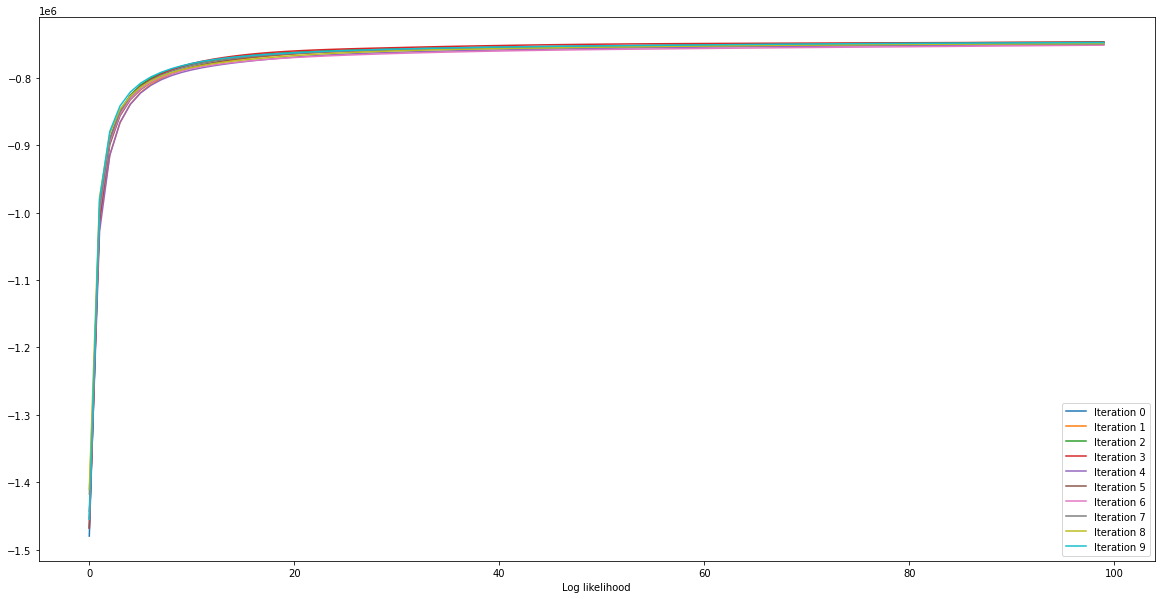

In [76]:
fig = plt.figure(figsize=(20,10))
for i in range(10):
    plt.plot(log_likelihood_list[i], label = 'Iteration {}'.format(i))
plt.legend()
plt.xlabel('Iteration')
plt.xlabel('Log likelihood')
plt.show()

### b.

In [89]:
movie_temp = best_model.movie
user_temp = best_model.user

In [90]:
def get_top10(movie_name, movie_matrix, movie):
    movie_index = movie[movie['movie_name'].str.contains(movie_name)].index[0]
    moive_vector = movie_matrix[movie_index] # 1 x d
    movie_df = pd.DataFrame(columns=['moive_name', 'distance'])
    for i in range(movie_matrix.shape[0]):
        distance = np.linalg.norm(moive_vector - movie_matrix[i])
        movie_df.loc[i] = [movie.iloc[i][0], distance]

    movie_df.sort_values(by='distance', ascending=True, inplace=True)

    movie_df = movie_df.iloc[1:]

    return movie_df.head(10)

In [91]:
get_top10('Star Wars', movie_temp, movie)

,moive_name,distance
171,"Empire Strikes Back, The (1980)",0.445791
173,Raiders of the Lost Ark (1981),0.677135
611,Lost Horizon (1937),0.804063
180,Return of the Jedi (1983),0.835454
11,"Usual Suspects, The (1995)",1.020989
209,Indiana Jones and the Last Crusade (1989),1.044661
0,Toy Story (1995),1.076388
63,"Shawshank Redemption, The (1994)",1.111324
1188,Prefontaine (1997),1.134340
193,"Sting, The (1973)",1.140013


In [92]:
get_top10('My Fair Lady', movie_temp, movie)

,moive_name,distance
142,"Sound of Music, The (1965)",0.814570
418,Mary Poppins (1964),0.938405
282,Emma (1996),0.977680
98,Snow White and the Seven Dwarfs (1937),1.064796
486,Roman Holiday (1953),1.097464
415,Old Yeller (1957),1.101847
587,Beauty and the Beast (1991),1.127027
131,"Wizard of Oz, The (1939)",1.197959
377,Miracle on 34th Street (1994),1.231906
419,Alice in Wonderland (1951),1.232574


In [93]:
get_top10('GoodFellas', movie_temp, movie)

,moive_name,distance
176,"Good, The Bad and The Ugly, The (1966)",0.474957
692,Casino (1995),0.822297
134,2001: A Space Odyssey (1968),0.880531
187,Full Metal Jacket (1987),0.897914
522,Cool Hand Luke (1967),0.908715
645,Once Upon a Time in the West (1969),0.943220
182,Alien (1979),1.056600
503,Bonnie and Clyde (1967),1.122853
237,Raising Arizona (1987),1.137493
156,Platoon (1986),1.138582


### Problem2

### a.

In [2]:
nyt_vocab = pd.read_csv('./hw3-data/nyt_vocab.dat', header=None)
nyt_vocab.shape

(3012, 1)

In [3]:
with open('./hw3-data/nyt_data.txt', 'r', encoding='utf-8-sig') as f:
    nyt_data = f.read().splitlines()

In [4]:
X_matrix = np.zeros((nyt_vocab.shape[0], len(nyt_data)))

for i in range(len(nyt_data)):
    for word in nyt_data[i].split(','):
        X_matrix[int(word.split(':')[0])-1, i] = int(word.split(':')[1])
X_matrix.shape

(3012, 8447)

In [5]:
SIGMA = 0.25
D = 25
LAMBDA = 1
N_1 = 3012
N_2 = 8447
EPSILON = 1e-16
print("Number of words: ", N_1)
print("Number of documents: ", N_2)
print('Number of topics: ', D)

Number of words:  3012
Number of documents:  8447
Number of topics:  25


In [6]:
class NMF:
    def __init__(self, n_1, n_2, d, n_iterations = 100) -> None:
        self.n_1 = n_1
        self.n_2 = n_2
        self.d = d
        self.n_iterations = n_iterations
        self.word = np.random.uniform(1, 2, size = (n_1, self.d)) # n1 x d
        self.doc = np.random.uniform(1, 2, size = (n_2, self.d)) # n2 x d

    def fit(self, X_matrix):
        div_list = []
        for _ in range(self.n_iterations):
            doc_temp = self.doc
            word_temp = self.word
            #     n_1 x d   @  d x n_2
            self.WH = (self.word @ self.doc.T)
            # n2 x d =   n2 x d  *       n2 x n1    @ n1 x d    / 1 x d
            self.doc = self.doc * ((X_matrix/(self.WH+EPSILON)).T @ self.word)/(np.sum(self.word, 0).reshape(1,-1) + EPSILON)
            
            self.WH = (self.word @ self.doc.T)
            # n1 x d  = n1 x d  *       n1 x n2    @ n2 x d    / 1 x d
            self.word = self.word * (X_matrix/(self.WH+EPSILON) @ self.doc)/(np.sum(self.doc, 0).reshape(1,-1) + EPSILON)

            self.WH = (self.word @ self.doc.T)
            div = self.divergence(X_matrix)
            div_list.append(div)


        return div_list
    
    def divergence(self, X_matrix):
        return np.sum(X_matrix * np.log(1/(self.WH+EPSILON)) + self.WH)


In [7]:
NMF_model = NMF(N_1, N_2, D, 100)
div_list = NMF_model.fit(X_matrix)

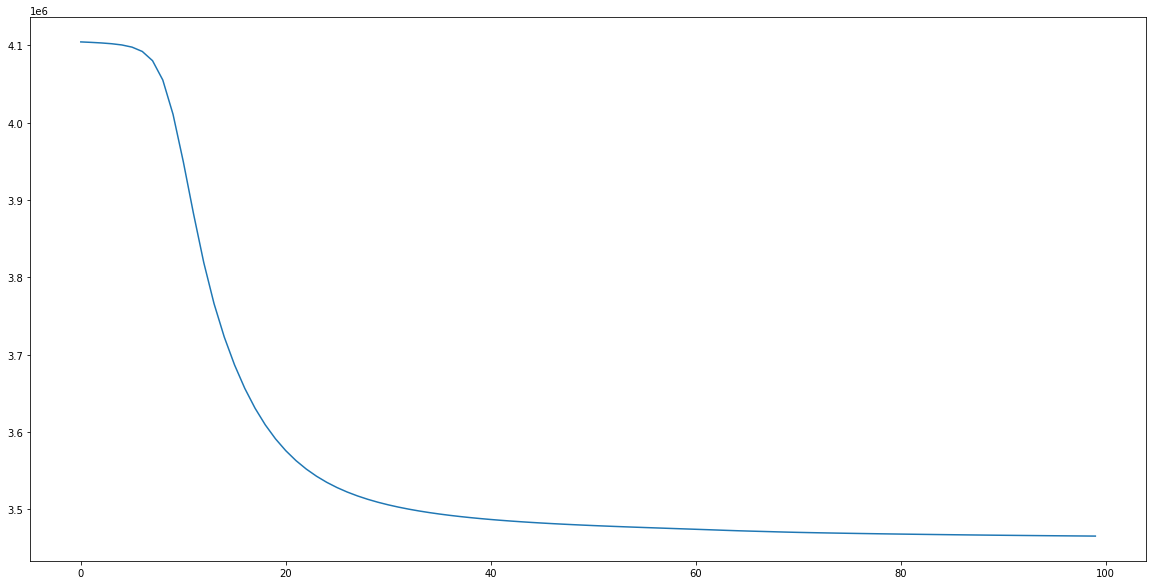

In [8]:
fig = plt.figure(figsize=(20,10))
plt.plot(div_list)
plt.show()

### b.

In [9]:
word_matrix = NMF_model.word
doc_matrix = NMF_model.doc
a = np.sum(word_matrix, 0).reshape(1,-1)
word_matrix = word_matrix/a
doc_matrix = doc_matrix/a


In [10]:
index_10 = np.argsort(word_matrix[:,0])[-10:]
nyt_vocab.iloc[index_10, 0]

496    investigation
443             file
404            trial
477            legal
313            judge
88            charge
48               law
126            court
162           lawyer
17              case
Name: 0, dtype: object

In [11]:
np.sort(word_matrix[:,0])[-10:]

array([0.00913168, 0.00976687, 0.00987673, 0.01108926, 0.0131158 ,
       0.01460211, 0.0162256 , 0.01976912, 0.02011422, 0.02199341])

In [12]:
test_result = pd.DataFrame(columns = ['topic', 'word', 'weight'])
test_result['word'] = nyt_vocab.iloc[index_10, 0]
test_result['weight'] = np.sort(word_matrix[:,0])[-10:]
test_result['topic'] = 'topic{}'.format(0)
test_result

,topic,word,weight
496,topic0,investigation,0.009132
443,topic0,file,0.009767
404,topic0,trial,0.009877
477,topic0,legal,0.011089
313,topic0,judge,0.013116
88,topic0,charge,0.014602
48,topic0,law,0.016226
126,topic0,court,0.019769
162,topic0,lawyer,0.020114
17,topic0,case,0.021993


In [12]:
result = np.empty((5,5), dtype=object)
for i in range(5):
    for j in range(5):
        current_index = i*5+j
        result_temp = pd.DataFrame(columns = ['topic', 'word', 'weight'])
        index_10 = np.argsort(word_matrix[:,current_index])[-10:]
        result_temp['word'] = nyt_vocab.iloc[index_10, 0]
        result_temp['weight'] = np.sort(word_matrix[:,current_index])[-10:]
        result_temp['topic'] = 'topic{}'.format(current_index)
        result[i,j] = result_temp

In [14]:
print(result)

[[      topic           word    weight
  496  topic0  investigation  0.009132
  443  topic0           file  0.009767
  404  topic0          trial  0.009877
  477  topic0          legal  0.011089
  313  topic0          judge  0.013116
  88   topic0         charge  0.014602
  48   topic0            law  0.016226
  126  topic0          court  0.019769
  162  topic0         lawyer  0.020114
  17   topic0           case  0.021993       topic        word    weight
                                       528  topic1       voter  0.011207
                                       84   topic1      leader  0.011742
                                       383  topic1  democratic  0.014204
                                       253  topic1  republican  0.016892
                                       120  topic1       party  0.017060
                                       319  topic1   candidate  0.017182
                                       216  topic1    election  0.017432
                          